## Xception модели разпознавания deepfakes

In [2]:
#!c1.4
import os
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPool2D,
)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from PIL import Image, ImageChops, ImageEnhance
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt

from data_prepare.dataset_tools import extract_zip_with_cleanup, prepare_and_save_data, create_data_generators
from data_prepare.plots import plot_history, confusion_matrix

In [5]:
def load_data(
    real_dir, fake_dir, val_size=0.15, test_size=0.15, random_state=42, max_samples=None
):
    """
    Загружает и разделяет данные на train/val/test с сохранением баланса классов

    Parameters:
        real_dir (str): Путь к реальным изображениям
        fake_dir (str): Путь к фейковым изображениям
        val_size (float): Доля валидационных данных
        test_size (float): Доля тестовых данных
        random_state (int): Seed для воспроизводимости
        max_samples (int): Макс. количество образцов каждого класса

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    X, y = [], []

    for label, dir_path in enumerate([real_dir, fake_dir]):
        images = [f for f in os.listdir(dir_path) 
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        if max_samples:
            images = images[:max_samples]
            
        for img_name in images:
            img = cv2.imread(os.path.join(dir_path, img_name))
            if img is None:
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299, 299))
            
            img = img.astype('float32') / 255.0
            
            X.append(img)
            y.append(label)
            
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), 
        random_state=random_state, stratify=y)
    
    test_size_adj = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size_adj,
        random_state=random_state, stratify=y_temp)
    
    print(f"Data loaded: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    print(f"Class distribution - Real(0)/Fake(1):")
    print(f"Train: {np.bincount(y_train)}")
    print(f"Val: {np.bincount(y_val)}")
    print(f"Test: {np.bincount(y_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Подготовка данных и выполнение

In [5]:
image_archive_path = "data/celeb/v1/"
fake_images_path, real_images_path = extract_zip_with_cleanup(image_archive_path)

In [ ]:
# X_train, X_val, X_test, y_train, y_val, y_test = load_data(
#     real_images_path, fake_images_path
# )

In [6]:
train_dir, val_dir, test_dir = prepare_and_save_data(real_images_path, fake_images_path)

In [7]:
train_gen, val_gen, test_gen = create_data_generators(train_dir, val_dir, test_dir)

Found 9073 images belonging to 2 classes.
Found 1944 images belonging to 2 classes.
Found 1946 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}
Train samples: 9073
Val samples: 1944
Test samples: 1946


### Model fitting

In [11]:
def build_xception_model(input_shape=(299, 299, 3), num_classes=1):
    """
    Строит модель на основе Xception для обнаружения дипфейков

    Параметры:
        input_shape: размер входного изображения (по умолчанию 299x299 для Xception)
        num_classes: 1 для бинарной классификации (sigmoid), 2 для softmax
    """

    base_model = Xception(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    base_model.trainable = False

    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(num_classes, activation="sigmoid" if num_classes == 1 else "softmax"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy" if num_classes == 1 else "categorical_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )

    return model, base_model

In [ ]:
def train_model(train_generator, val_generator):
    """
    Обучает модель на данных, загруженных в память

    Parameters:
        train_generator (np.array): Тренировочные изображения
        val_generator (np.array): Тестовые изображения

    Returns:
        tuple: (model, history) - обученная модель и история обучения
    """
    model, _ = build_xception_model()

    history = model.fit(
        train_generator,
        batch_size=32,
        epochs=10,
        validation_data=val_generator,
        callbacks=[
            ModelCheckpoint("best_model.h5", monitor="val_pr_auc", save_best_only=True),
            EarlyStopping(monitor="val_loss", patience=3),
        ],
    )

    return model, history

In [ ]:
trained_model, histories = train_model(train_gen, val_gen)

2025-04-28 19:35:28.471718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5
2025-04-28 19:35:31.451634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/10


2025-04-28 19:35:35.231181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-04-28 19:35:39.403835: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3f0457f340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 19:35:39.403881: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-28 19:35:39.580353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 19:35:40.935433: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/284 [==============================] - ETA: 0s - loss: 0.5545 - precision: 0.2627 - recall: 0.1773 - auc: 0.5748

2025-04-28 19:36:47.964834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


284/284 [==============================] - 93s 294ms/step - loss: 0.5545 - precision: 0.2627 - recall: 0.1773 - auc: 0.5748 - val_loss: 0.4415 - val_precision: 0.5692 - val_recall: 0.1160 - val_auc: 0.6197
Epoch 2/10
284/284 [==============================] - 70s 246ms/step - loss: 0.4780 - precision: 0.4226 - recall: 0.1961 - auc: 0.6394 - val_loss: 0.4393 - val_precision: 0.5614 - val_recall: 0.1003 - val_auc: 0.6227
Epoch 3/10
284/284 [==============================] - 70s 247ms/step - loss: 0.4537 - precision: 0.4783 - recall: 0.2216 - auc: 0.6616 - val_loss: 0.4282 - val_precision: 0.6444 - val_recall: 0.0909 - val_auc: 0.6603
Epoch 4/10
284/284 [==============================] - 71s 250ms/step - loss: 0.4332 - precision: 0.5204 - recall: 0.2398 - auc: 0.6887 - val_loss: 0.4321 - val_precision: 0.5200 - val_recall: 0.1223 - val_auc: 0.6573
Epoch 5/10
284/284 [==============================] - 71s 250ms/step - loss: 0.4178 - precision: 0.5225 - recall: 0.2263 - auc: 0.7074 - val_lo

In [10]:
trained_model.save("xception_deepfake_model.h5")

In [5]:
trained_model = tf.keras.models.load_model("xception_deepfake_model.h5")

2025-04-29 19:04:44.008857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
#!gt4.1
test_loss, test_precision, test_recall, test_auc = trained_model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_auc:.4f}")

NameError: name 'trained_model' is not defined

### Fine tuned

In [9]:
def train_model_finetune(train_generator, val_generator, fine_tune=False, initial_epochs=10, fine_tune_epochs=10):
    """
    Двухэтапное обучение с возможностью дообучения
    
    Parameters:
        train_generator: генератор тренировочных данных
        val_generator: генератор валидационных данных
        fine_tune: выполнять ли дообучение
        initial_epochs: количество эпох начального обучения
        fine_tune_epochs: количество эпох дообучения
    """
    model, base_model = build_xception_model()
    
    history = model.fit(
        train_generator,
        epochs=initial_epochs,
        validation_data=val_generator,
        callbacks=[
            ModelCheckpoint("initial_model.h5", monitor="val_auc", save_best_only=True, mode="max"),
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ]
    )
    
    if not fine_tune:
        return model, history
    
    base_model.trainable = True
    
    for layer in base_model.layers[:int(len(base_model.layers)*0.7)]:
        layer.trainable = False
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ]
    )
    
    fine_tune_history = model.fit(
        train_generator,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_generator,
        callbacks=[
            ModelCheckpoint("fine_tuned_model.h5", monitor="val_auc", save_best_only=True, mode="max"),
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        ]
    )
    
    # Объединяем истории обучения
    full_history = {
        k: history.history[k] + fine_tune_history.history[k]
        for k in history.history
    }
    
    return model, full_history

In [12]:
finetune_trained_model, finetune_histories = train_model_finetune(train_gen, val_gen, fine_tune=True, initial_epochs=5, fine_tune_epochs=10)

2025-05-01 18:25:23.772710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5
2025-05-01 18:25:30.740363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/5


2025-05-01 18:25:34.791536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-05-01 18:25:39.748414: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd0a85708e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-01 18:25:39.748457: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-05-01 18:25:39.957591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-01 18:25:41.304271: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/284 [==============================] - ETA: 0s - loss: 0.5566 - precision: 0.2801 - recall: 0.2001 - auc: 0.5717

2025-05-01 18:26:45.727513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


284/284 [==============================] - 97s 304ms/step - loss: 0.5566 - precision: 0.2801 - recall: 0.2001 - auc: 0.5717 - val_loss: 0.4377 - val_precision: 0.5135 - val_recall: 0.1191 - val_auc: 0.6272
Epoch 2/5
284/284 [==============================] - 78s 275ms/step - loss: 0.4767 - precision: 0.4333 - recall: 0.2116 - auc: 0.6383 - val_loss: 0.4271 - val_precision: 0.5588 - val_recall: 0.1191 - val_auc: 0.6556
Epoch 3/5
284/284 [==============================] - 79s 277ms/step - loss: 0.4537 - precision: 0.4849 - recall: 0.2263 - auc: 0.6651 - val_loss: 0.4302 - val_precision: 0.5588 - val_recall: 0.1191 - val_auc: 0.6602
Epoch 4/5
284/284 [==============================] - 79s 279ms/step - loss: 0.4394 - precision: 0.5164 - recall: 0.2330 - auc: 0.6785 - val_loss: 0.4325 - val_precision: 0.5455 - val_recall: 0.1317 - val_auc: 0.6701
Epoch 5/5
284/284 [==============================] - 79s 279ms/step - loss: 0.4206 - precision: 0.5190 - recall: 0.2297 - auc: 0.7061 - val_loss: 

2025-05-01 18:32:24.112279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 6/15
284/284 [==============================] - ETA: 0s - loss: 0.4418 - precision: 0.4648 - recall: 0.2391 - auc: 0.6777

2025-05-01 18:34:17.109109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


284/284 [==============================] - 139s 440ms/step - loss: 0.4418 - precision: 0.4648 - recall: 0.2391 - auc: 0.6777 - val_loss: 0.4187 - val_precision: 0.5221 - val_recall: 0.1850 - val_auc: 0.6959
Epoch 7/15
284/284 [==============================] - 123s 432ms/step - loss: 0.4015 - precision: 0.5540 - recall: 0.2653 - auc: 0.7346 - val_loss: 0.3970 - val_precision: 0.5699 - val_recall: 0.1661 - val_auc: 0.7434
Epoch 8/15
284/284 [==============================] - 123s 434ms/step - loss: 0.3654 - precision: 0.6134 - recall: 0.3143 - auc: 0.7858 - val_loss: 0.3700 - val_precision: 0.6600 - val_recall: 0.2069 - val_auc: 0.7810
Epoch 9/15
284/284 [==============================] - 123s 434ms/step - loss: 0.3214 - precision: 0.6815 - recall: 0.3909 - auc: 0.8429 - val_loss: 0.3348 - val_precision: 0.7234 - val_recall: 0.3197 - val_auc: 0.8250
Epoch 10/15
284/284 [==============================] - 123s 434ms/step - loss: 0.2856 - precision: 0.7276 - recall: 0.4681 - auc: 0.8818 - 

AttributeError: 'dict' object has no attribute 'history'

In [13]:
finetune_trained_model.save("xception_finetune_deepfake_model.h5")

In [ ]:
finetune_history_df = pd.DataFrame(finetune_histories.history)
history_df.to_csv('results/finetune_training_history.csv', index=False)

In [8]:
#!gt4.1
finetune_trained_model = tf.keras.models.load_model("xception_finetune_deepfake_model.h5")
test_loss, test_precision, test_recall, test_auc = finetune_trained_model.evaluate(test_gen)

print(f"\nTest AUC: {test_auc:.4f}, loss: {test_loss:.4f}, pression: {test_precision:.4f}, recall: {test_recall:4f}")

2025-05-02 07:13:17.951259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


61/61 [==============================] - 186s 3s/step - loss: 0.2381 - precision: 0.8351 - recall: 0.5063 - auc: 0.9311


ValueError: Format specifier missing precision

### Analyze results

In [12]:
finetune_loaded_history_df = pd.read_csv('results/finetune_training_history.csv')
finetune_loaded_history = {'history': finetune_loaded_history_df.to_dict()}

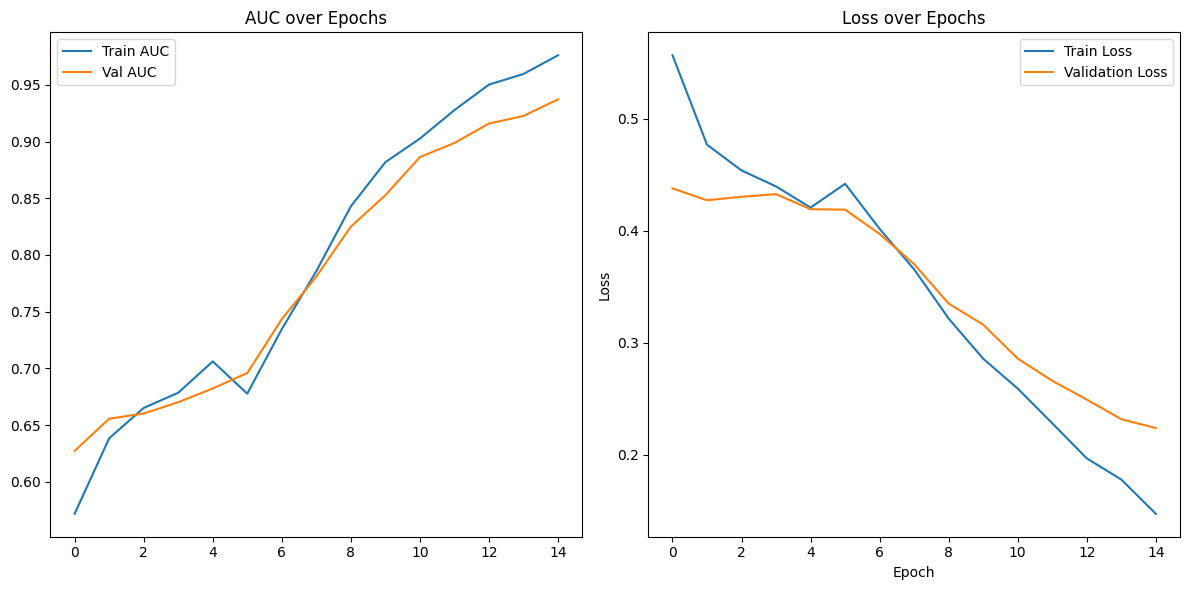

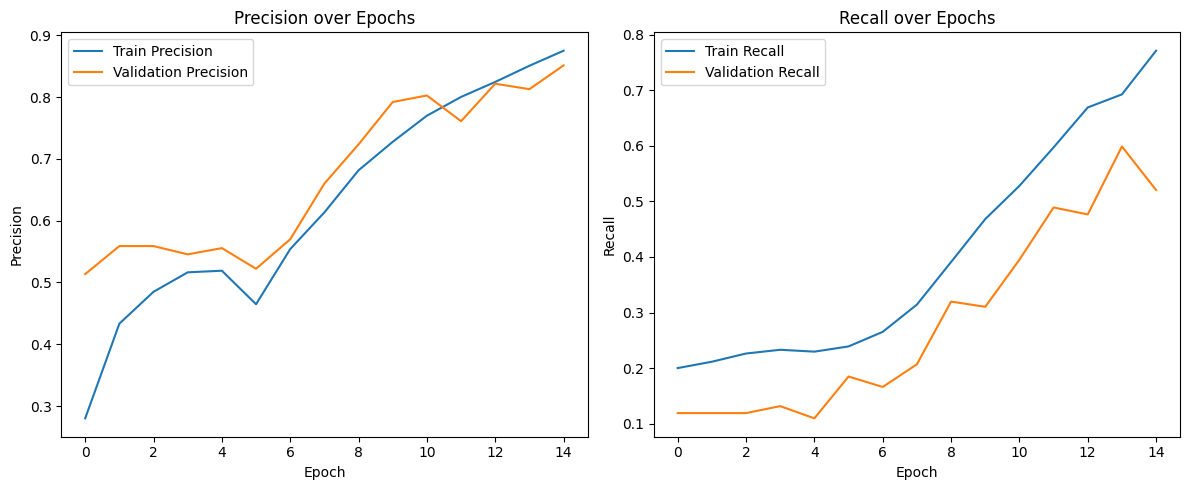

<Figure size 640x480 with 0 Axes>

In [13]:
plot_history(finetune_loaded_history_df)

In [17]:
y_pred = finetune_trained_model.predict(test_gen)

2025-05-02 07:21:53.574756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


61/61 [==============================] - 184s 3s/step


TypeError: confusion_matrix() missing 1 required positional argument: 'test_recall'

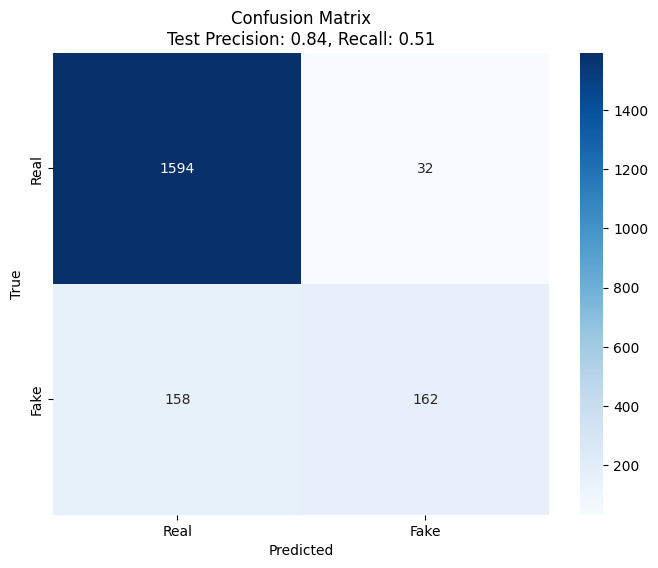

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_gen.labels
    
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix\nTest Precision: {test_precision:.2f}, Recall: {test_recall:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()